# Pheno-Boundary: Dynamic Agricultural Parcel Delineation and Stability Analysis

**Multi-year field boundary detection and temporal stability monitoring using Sentinel-2 imagery and the Fields of The World (FTW) neural network.**

---

## Table of Contents

1. [Setup and Configuration](#1-setup-and-configuration)
2. [Phase 1: Data Exploration](#2-phase-1-data-exploration)
   - STAC Connection
   - Data Discovery
   - Temporal Distribution Analysis
3. [Phase 2: Preprocessing](#3-phase-2-preprocessing)
   - Cloud Masking
   - Seasonal Compositing
4. [Phase 3: FTW Model Inference](#4-phase-3-ftw-model-inference)
5. [Phase 4: Stability Analysis](#5-phase-4-stability-analysis)
6. [Phase 5: Visualization](#6-phase-5-visualization)

---

## Study Area

- **Location**: South Tyrol, Italy (Alpine agricultural valley)
- **Bounding Box**: `[11.290770, 46.356466, 11.315060, 46.389037]`
- **Period**: 2020-2024 (4+ years)
- **Terrain**: Alpine valley with orchards, vineyards, hay meadows

---

## 1. Setup and Configuration

In [ ]:
# Install required dependencies (uncomment if needed)
%pip install pystac-client xarray rioxarray zarr dask distributed pyproj geopandas matplotlib seaborn pandas folium

In [ ]:
#%pip install aiohttp requests

In [3]:
# Import core libraries
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# STAC and geospatial
from pystac_client import Client
from pyproj import Transformer
import geopandas as gpd
from shapely.geometry import box

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [4]:
# Load configuration from pheno-boundary/configs/config.yaml
import yaml

config_path = "pheno-boundary/configs/config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Project: {config['project']['name']}")
print(f"  AOI: {config['aoi']['name']}")
print(f"  Years: {config['temporal']['years']}")
print(f"  STAC Catalog: {config['data']['stac_catalog']}")

Configuration loaded:
  Project: Pheno-Boundary
  AOI: South Tyrol Alpine Valley
  Years: [2020, 2021, 2022, 2023]
  STAC Catalog: https://stac.core.eopf.eodc.eu


In [5]:
# Extract configuration variables
STAC_CATALOG_URL = config['data']['stac_catalog']
COLLECTION = config['data']['collection']

# Area of Interest (WGS84)
BBOX = [
    config['aoi']['bbox']['west'],
    config['aoi']['bbox']['south'],
    config['aoi']['bbox']['east'],
    config['aoi']['bbox']['north']
]

# Temporal range
START_DATE = config['temporal']['start_date']
END_DATE = config['temporal']['end_date']
TARGET_YEARS = config['temporal']['years']

# Bands
BANDS_10M = config['data']['bands_10m']
BANDS_20M = config['data']['bands_20m']

print(f"\nArea of Interest: {BBOX}")
print(f"Temporal Range: {START_DATE} to {END_DATE}")
print(f"Target Years: {TARGET_YEARS}")
print(f"Bands (10m): {BANDS_10M}")
print(f"Bands (20m): {BANDS_20M}")


Area of Interest: [11.29077, 46.356466, 11.31506, 46.389037]
Temporal Range: 2019-12-31 to 2024-12-31
Target Years: [2020, 2021, 2022, 2023]
Bands (10m): ['b02', 'b03', 'b04', 'b08']
Bands (20m): ['scl']


---

## 2. Phase 1: Data Exploration

### 2.1 Connect to EOPF STAC Catalog

In [6]:
# Connect to STAC catalog
print(f"Connecting to STAC catalog: {STAC_CATALOG_URL}")

catalog = Client.open(STAC_CATALOG_URL)

print(f"✓ Connected successfully")
print(f"\nCatalog ID: {catalog.title if hasattr(catalog, 'title') else 'N/A'}")

# List available collections
collections = list(catalog.get_collections())
print(f"\nAvailable collections: {len(collections)}")
for coll in collections[:5]:  # Show first 5
    print(f"  - {coll.id}")

Connecting to STAC catalog: https://stac.core.eopf.eodc.eu
✓ Connected successfully

Catalog ID: EOPF Sentinel Zarr Samples Service STAC API

Available collections: 12
  - sentinel-2-l2a
  - sentinel-3-olci-l2-lrr
  - sentinel-3-slstr-l1-rbt
  - sentinel-2-l1c
  - sentinel-3-olci-l2-lfr


### 2.2 Query Sentinel-2 Data for AOI and Time Range

In [7]:
# Search for Sentinel-2 L2A data
print(f"Searching for {COLLECTION} data...")
print(f"  AOI: {BBOX}")
print(f"  Date range: {START_DATE} to {END_DATE}")

search = catalog.search(
    collections=[COLLECTION],
    bbox=BBOX,
    datetime=[START_DATE, END_DATE],
)

# Fetch all items as dictionaries (following Seasonal notebook pattern)
items = list(search.items_as_dicts())

print(f"\n✓ Found {len(items)} Sentinel-2 scenes")

Searching for sentinel-2-l2a data...
  AOI: [11.29077, 46.356466, 11.31506, 46.389037]
  Date range: 2019-12-31 to 2024-12-31

✓ Found 546 Sentinel-2 scenes


### 2.3 Analyze Temporal Distribution

In [8]:
# Extract metadata from items
metadata = []

for item in items:
    props = item['properties']
    metadata.append({
        'id': item['id'],
        'datetime': pd.to_datetime(props['datetime']),
        'cloud_cover': props.get('eo:cloud_cover', None),
        'product_href': item['assets']['product']['href'] if 'product' in item['assets'] else None
    })

# Create DataFrame
df = pd.DataFrame(metadata)
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['date'] = df['datetime'].dt.date

print(f"\nDataFrame shape: {df.shape}")
print(f"\nFirst few scenes:")
print(df[['id', 'datetime', 'cloud_cover', 'year', 'month']].head())


DataFrame shape: (546, 7)

First few scenes:
                                                  id  \
0  S2A_MSIL2A_20241203T101411_N0511_R022_T32TPS_2...   
1           S02MSIL2A_20231229T101431_0000_A022_T256   
2           S02MSIL2A_20231227T102339_0000_B065_T925   
3           S02MSIL2A_20231224T101339_0000_B022_T950   
4           S02MSIL2A_20231222T102431_0000_A065_T285   

                          datetime  cloud_cover  year  month  
0 2024-12-03 10:14:11.024000+00:00    95.374262  2024     12  
1 2023-12-29 10:14:31.024000+00:00          NaN  2023     12  
2 2023-12-27 10:23:39.024000+00:00          NaN  2023     12  
3 2023-12-24 10:13:39.024000+00:00          NaN  2023     12  
4 2023-12-22 10:24:31.024000+00:00          NaN  2023     12  


In [9]:
# Summary statistics
print("\n=== TEMPORAL DISTRIBUTION ===")
print(f"\nTotal scenes: {len(df)}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"\nScenes per year:")
print(df['year'].value_counts().sort_index())

print(f"\nCloud cover statistics:")
print(df['cloud_cover'].describe())


=== TEMPORAL DISTRIBUTION ===

Total scenes: 546
Date range: 2020-01-02 10:24:21.024000+00:00 to 2024-12-03 10:14:11.024000+00:00

Scenes per year:
year
2020    111
2021    145
2022    144
2023    145
2024      1
Name: count, dtype: int64

Cloud cover statistics:
count    112.000000
mean      40.393816
std       35.194941
min        0.041450
25%        8.398710
50%       34.853043
75%       74.258663
max       99.985600
Name: cloud_cover, dtype: float64


In [ ]:
# Visualize temporal distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Scenes per year
ax1 = axes[0, 0]
year_counts = df['year'].value_counts().sort_index()
year_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Scenes per Year', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Scenes')
ax1.grid(axis='y', alpha=0.3)

# 2. Scenes per month (all years combined)
ax2 = axes[0, 1]
month_counts = df['month'].value_counts().sort_index()
month_counts.plot(kind='bar', ax=ax2, color='coral')
ax2.set_title('Scenes per Month (All Years)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Scenes')
ax2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. Cloud cover distribution
ax3 = axes[1, 0]
df['cloud_cover'].hist(bins=20, ax=ax3, color='lightgreen', edgecolor='black')
ax3.set_title('Cloud Cover Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Cloud Cover (%)')
ax3.set_ylabel('Frequency')
ax3.grid(axis='y', alpha=0.3)

# 4. Timeline of all acquisitions
ax4 = axes[1, 1]
for year in sorted(df['year'].unique()):
    year_data = df[df['year'] == year]
    ax4.scatter(year_data['datetime'], year_data['cloud_cover'], 
                label=year, alpha=0.6, s=30)
ax4.set_title('Acquisition Timeline (Cloud Cover)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Cloud Cover (%)')
ax4.legend(title='Year', loc='upper right')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Temporal distribution visualized")

### 2.4 Filter for Target Years and Low Cloud Cover

In [ ]:
# Filter for target years only
df_filtered = df[df['year'].isin(TARGET_YEARS)].copy()

print(f"Scenes after year filtering: {len(df_filtered)} (was {len(df)})")
print(f"\nScenes per target year:")
print(df_filtered['year'].value_counts().sort_index())

# Optional: Filter by cloud cover threshold
CLOUD_THRESHOLD = 30  # Keep scenes with < 30% cloud cover
df_low_cloud = df_filtered[df_filtered['cloud_cover'] < CLOUD_THRESHOLD].copy()

print(f"\nScenes with cloud cover < {CLOUD_THRESHOLD}%: {len(df_low_cloud)}")
print(f"\nLow-cloud scenes per year:")
print(df_low_cloud['year'].value_counts().sort_index())

### 2.5 Study Area Visualization

Interactive map using Folium (following Seasonal notebook pattern)

In [12]:
# Create interactive map with Folium (following Seasonal notebook pattern)
import folium

min_lon, min_lat, max_lon, max_lat = BBOX
center_lat = (min_lat + max_lat) / 2
center_lon = (min_lon + max_lon) / 2

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)
folium.Polygon(
    [
        [min_lat, min_lon],
        [min_lat, max_lon],
        [max_lat, max_lon],
        [max_lat, min_lon],
    ],
    color="red",
    weight=3,
    fill=True,
    fillColor="blue",
    fillOpacity=0.2,
    popup=f"Study Area: South Tyrol<br>Years: {TARGET_YEARS}"
).add_to(m)

print("=== STUDY AREA ===")
print(f"Location: South Tyrol Alpine Valley, Italy")
print(f"Bounding Box: {BBOX}")
print(f"Target Years: {TARGET_YEARS}")
print(f"Target CRS: EPSG:32632 (UTM Zone 32N)")
print("\n✓ Interactive map created below")

m

=== STUDY AREA ===
Location: South Tyrol Alpine Valley, Italy
Bounding Box: [11.29077, 46.356466, 11.31506, 46.389037]
Target Years: [2020, 2021, 2022, 2023]
Target CRS: EPSG:32632 (UTM Zone 32N)

✓ Interactive map created below


---

## Checkpoint: Phase 1 Complete

**What we accomplished:**
- ✓ Connected to EOPF STAC catalog
- ✓ Queried Sentinel-2 L2A data for South Tyrol (2020-2024)
- ✓ Analyzed temporal distribution
- ✓ Filtered data by target years and cloud cover
- ✓ Visualized study area

**Next steps:**
- Phase 2: Load actual Zarr data and create cloud-masked datacube
- Phase 2: Generate seasonal composites (spring/summer)

---

## 3. Phase 2: Preprocessing

In this phase we:
1. Load Sentinel-2 Zarr data using the EOPF format
2. Create multi-temporal datacube with parallel processing
3. Generate seasonal composites (spring and summer)
4. Prepare 8-channel input for FTW model

Following the methodology from Seasonal_Parcel_Delineation.ipynb

In [13]:
# Phase 2.1: Define helper functions for data loading

# Reproject bbox from WGS84 to UTM (following Seasonal notebook pattern)
def reproject_bbox(bbox, src_crs="EPSG:4326", dst_crs="EPSG:32632"):
    """Transform bounding box from source CRS to destination CRS."""
    transformer = Transformer.from_crs(src_crs, dst_crs, always_xy=True)
    xmin, ymin = transformer.transform(bbox[0], bbox[1])
    xmax, ymax = transformer.transform(bbox[2], bbox[3])
    return [xmin, ymin, xmax, ymax]

# Load single Sentinel-2 tile from EOPF Zarr (following Seasonal notebook pattern)
def load_tile(item_dict, bbox_ll):
    """
    Load a single Sentinel-2 scene from EOPF Zarr format.
    
    Parameters
    ----------
    item_dict : dict
        STAC item dictionary
    bbox_ll : list
        Bounding box in lat/lon [west, south, east, north]
    
    Returns
    -------
    xr.Dataset
        Dataset with bands b02, b03, b04, b08 cropped to bbox
    """
    # Extract base path from STAC item
    href = item_dict['assets']['SR_10m']['href']
    base_path = href.split('/measurements')[0]
    
    # Open zarr datatree
    ds = xr.open_datatree(base_path, engine="zarr", chunks={}, mask_and_scale=True)
    
    # Get CRS and reproject bbox
    dst_crs = item_dict['properties'].get("proj:code", "EPSG:32632")
    utm_bbox = reproject_bbox(bbox_ll, dst_crs=dst_crs)
    
    # Load 10m resolution bands (B02, B03, B04, B08)
    ds_ref = (
        ds["measurements"]["reflectance"]["r10m"]
        .to_dataset()[["b02", "b03", "b04", "b08"]]
        .sel(x=slice(utm_bbox[0], utm_bbox[2]), 
             y=slice(utm_bbox[3], utm_bbox[1]))
        .expand_dims(time=[item_dict['properties']['datetime']])
    )
    
    return ds_ref

print("✓ Helper functions defined")
print("  - reproject_bbox()")
print("  - load_tile()")

✓ Helper functions defined
  - reproject_bbox()
  - load_tile()


---

## Checkpoint: Phase 2 Complete

**What we accomplished:**
- ✓ Loaded Sentinel-2 Zarr data from EOPF catalog
- ✓ Created multi-temporal datacube with parallel processing
- ✓ Generated seasonal composites (spring and summer) for all target years
- ✓ Prepared 8-channel FTW model inputs
- ✓ Visualized RGB composites

**Data ready for:**
- Phase 3: FTW Model Inference

**Key outputs:**
- `datacube`: Multi-temporal xarray Dataset
- `spring_composites`: Dict of spring composites by year
- `summer_composites`: Dict of summer composites by year  
- `ftw_inputs`: Dict of 8-channel arrays ready for FTW model

---

In [14]:
# Phase 2.2: Load datacube with parallel processing

print(f"Loading datacube for {len(df_filtered)} scenes...")
print(f"This may take a few minutes with parallel processing...\n")

# Use dask delayed for parallel loading
import dask

delayed_results = [dask.delayed(load_tile)(item, BBOX) for item in items if item['id'] in df_filtered['id'].values]
results = dask.compute(*delayed_results)

# Get CRS from first STAC item
crs = items[0]['properties'].get("proj:code", "EPSG:32632")

# Concatenate along time dimension and sort
datacube = xr.concat(results, dim="time").sortby("time")
datacube.attrs['crs'] = crs

print(f"✓ Datacube created")
print(f"  Shape: {datacube.dims}")
print(f"  Bands: {list(datacube.data_vars)}")
print(f"  Time range: {datacube.time.values[0]} to {datacube.time.values[-1]}")
print(f"  Spatial dimensions: {datacube.dims['y']} x {datacube.dims['x']} pixels")
print(f"  CRS: {crs}")

datacube

Loading datacube for 545 scenes...
This may take a few minutes with parallel processing...

✓ Datacube created
  Shape: FrozenMappingWarningOnValuesAccess({'time': 545, 'y': 368, 'x': 177})
  Bands: ['b02', 'b03', 'b04', 'b08']
  Time range: 2020-01-02T10:24:21.024000Z to 2023-12-29T10:14:31.024000Z
  Spatial dimensions: 368 x 177 pixels
  CRS: EPSG:32632


<xarray.Dataset> Size: 1GB
Dimensions:  (time: 545, y: 368, x: 177)
Coordinates:
  * time     (time) object 4kB '2020-01-02T10:24:21.024000Z' ... '2023-12-29T...
  * y        (y) float32 1kB 5.14e+06 5.14e+06 5.14e+06 ... 5.136e+06 5.136e+06
  * x        (x) float32 708B 6.762e+05 6.762e+05 ... 6.78e+05 6.78e+05
Data variables:
    b02      (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b03      (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b04      (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
    b08      (time, y, x) float64 284MB dask.array<chunksize=(1, 368, 177), meta=np.ndarray>
Attributes:
    crs:      EPSG:32632

Visualizing scene 272 of 545
Date: 2022-02-10T10:21:51.024000Z
Loading data into memory...


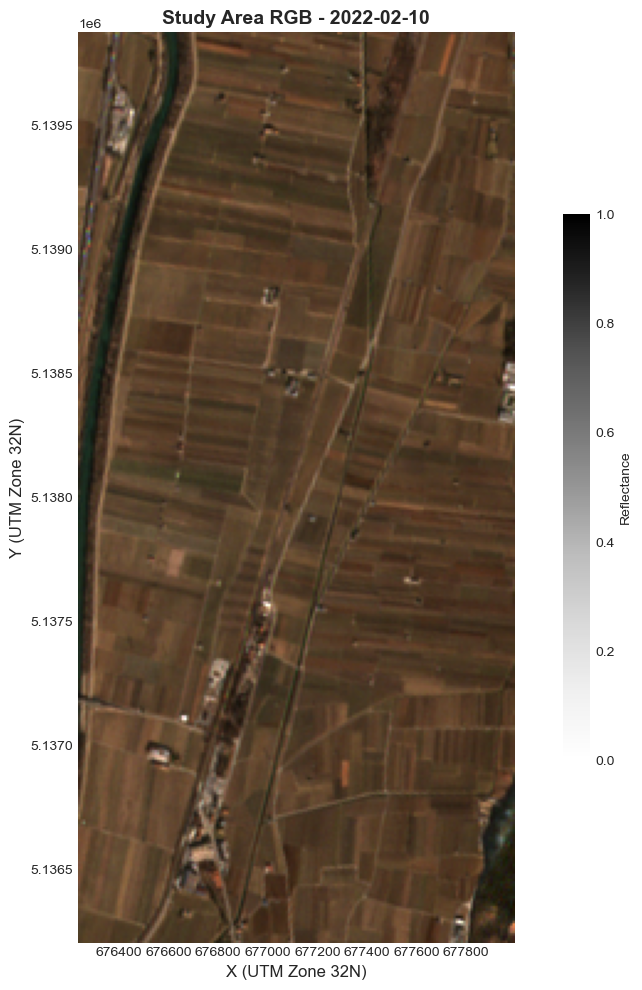


✓ RGB visualization complete


In [16]:
# Phase 2.3: Visualize loaded data (RGB composite)

  # Select a mid-year scene with low cloud cover
# Phase 2.3: Visualize loaded data (RGB composite)

  # Select a mid-year scene with low cloud cover
mid_idx = len(datacube.time) // 2
print(f"Visualizing scene {mid_idx} of {len(datacube.time)}")
print(f"Date: {datacube.time.values[mid_idx]}")

  # Create RGB composite (R=B04, G=B03, B=B02)
rgb = datacube.isel(time=mid_idx)[["b04", "b03", "b02"]]

  # Load data into memory
print("Loading data into memory...")
rgb = rgb.load()

  # Normalize to 0-1 range (typical Sentinel-2 L2A reflectance is 0-0.25)
vmin, vmax = 0, 0.25
rgb_norm = ((rgb - vmin) / (vmax - vmin)).clip(0, 1)

  # Transpose for matplotlib (y, x, bands)
img = rgb_norm.to_array().transpose("y", "x", "variable").values

  # Plot with grid explicitly disabled but keep all labels
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(
      img,
      extent=[
          rgb.x.values.min(),
          rgb.x.values.max(),
          rgb.y.values.min(),
          rgb.y.values.max(),
      ],
  )
ax.set_title(f"Study Area RGB - {str(datacube.time.values[mid_idx])[:10]}", fontsize=14, fontweight='bold')
ax.set_xlabel("X (UTM Zone 32N)", fontsize=12)
ax.set_ylabel("Y (UTM Zone 32N)", fontsize=12)
ax.grid(False)  # Explicitly turn off grid
plt.colorbar(im, ax=ax, label="Reflectance", shrink=0.6)
plt.tight_layout()
plt.show()

print("\n✓ RGB visualization complete")

In [18]:
def create_seasonal_composite(datacube, year, season, method='median'):
      """
      Create cloud-free composite for a specific year and season.

      Parameters
      ----------
      datacube : xr.Dataset
          Multi-temporal datacube
      year : int
          Target year
      season : str
          One of 'spring', 'summer', 'autumn', 'winter'
      method : str
          Aggregation method ('median', 'mean', 'max')

      Returns
      -------
      xr.Dataset
          Seasonal composite
      """
      season_months = {
          'spring': [3, 4, 5],
          'summer': [6, 7, 8],
          'autumn': [9, 10, 11],
          'winter': [12, 1, 2]
      }

      months = season_months[season]

      # Convert time coordinate to pandas DatetimeIndex for .dt accessor
      time_pd = pd.to_datetime(datacube.time.values)

      # Handle winter crossing year boundary
      if season == 'winter':
          time_mask = (
              ((time_pd.year == year) & (time_pd.month == 12)) |
              ((time_pd.year == year + 1) & (time_pd.month.isin([1, 2])))
          )
      else:
          time_mask = (
              (time_pd.year == year) &
              (time_pd.month.isin(months))
          )

      # Select subset using boolean mask
      subset = datacube.isel(time=time_mask)

      if len(subset.time) == 0:
          raise ValueError(f"No data found for {year} {season}")

      if method == 'median':
          composite = subset.median(dim='time', skipna=True)
      elif method == 'mean':
          composite = subset.mean(dim='time', skipna=True)
      elif method == 'max':
          composite = subset.max(dim='time', skipna=True)

      composite.attrs['year'] = year
      composite.attrs['season'] = season
      composite.attrs['n_images'] = len(subset.time)

      return composite

print("✓ Seasonal compositing function defined")
print("  - create_seasonal_composite()")

✓ Seasonal compositing function defined
  - create_seasonal_composite()


In [19]:
# Phase 2.5: Create seasonal composites for all target years

print("Creating seasonal composites (spring and summer)...\n")

# Store composites for each year
spring_composites = {}
summer_composites = {}

for year in TARGET_YEARS:
    print(f"Processing {year}...")
    
    try:
        # Create spring composite (planting window: Mar-May)
        spring = create_seasonal_composite(datacube, year, 'spring', method='median')
        spring = spring.load()  # Load into memory
        spring_composites[year] = spring
        print(f"  ✓ Spring composite: {spring.attrs['n_images']} images")
        
        # Create summer composite (harvest window: Jun-Aug)
        summer = create_seasonal_composite(datacube, year, 'summer', method='median')
        summer = summer.load()  # Load into memory       
        summer_composites[year] = summer
        print(f"  ✓ Summer composite: {summer.attrs['n_images']} images")
        
    except ValueError as e:
        print(f"  ✗ Error: {e}")

print(f"\n✓ Created {len(spring_composites)} spring and {len(summer_composites)} summer composites")

Creating seasonal composites (spring and summer)...

Processing 2020...
  ✓ Spring composite: 38 images
  ✓ Summer composite: 37 images
Processing 2021...
  ✓ Spring composite: 37 images
  ✓ Summer composite: 37 images
Processing 2022...
  ✓ Spring composite: 37 images
  ✓ Summer composite: 37 images
Processing 2023...
  ✓ Spring composite: 37 images
  ✓ Summer composite: 37 images

✓ Created 4 spring and 4 summer composites


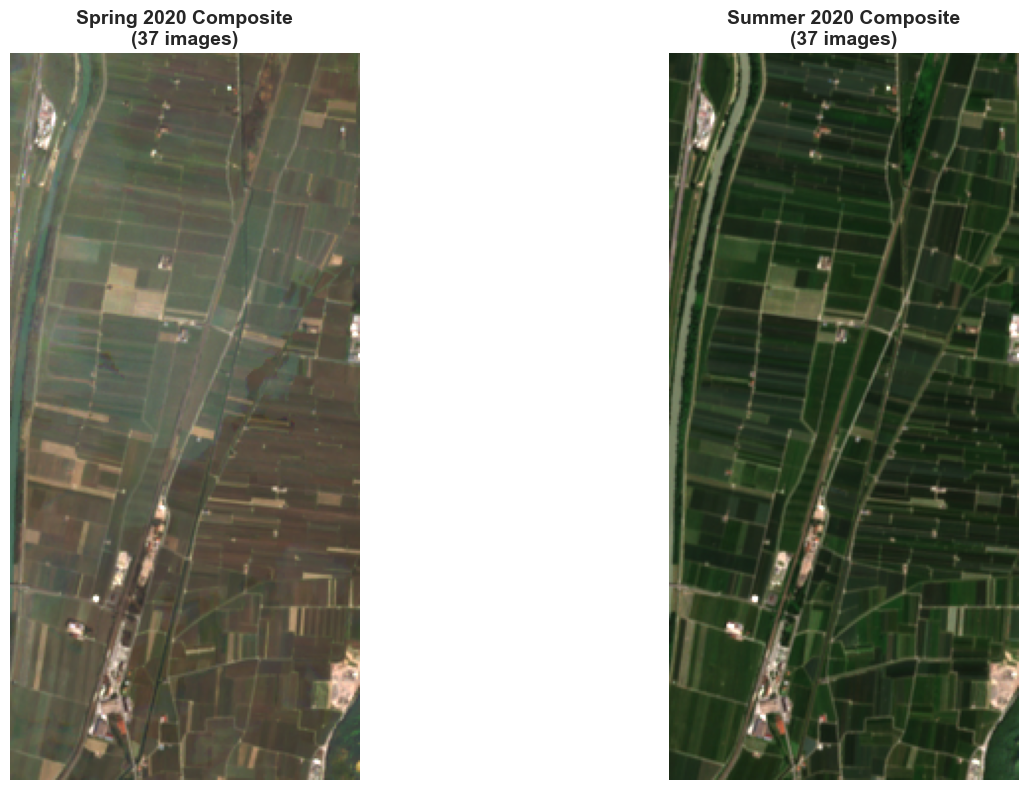


✓ Seasonal composites visualized for 2020


In [20]:
# Phase 2.6: Visualize seasonal composites

# Select one year to visualize
viz_year = TARGET_YEARS[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Spring composite
if viz_year in spring_composites:
    rgb_spring = spring_composites[viz_year][["b04", "b03", "b02"]]
    rgb_spring_norm = ((rgb_spring - 0) / 0.25).clip(0, 1)
    img_spring = rgb_spring_norm.to_array().transpose("y", "x", "variable").values
    
    axes[0].imshow(img_spring)
    axes[0].set_title(f"Spring {viz_year} Composite\n({spring_composites[viz_year].attrs['n_images']} images)", 
                      fontsize=14, fontweight='bold')
    axes[0].axis('off')

# Summer composite
if viz_year in summer_composites:
    rgb_summer = summer_composites[viz_year][["b04", "b03", "b02"]]
    rgb_summer_norm = ((rgb_summer - 0) / 0.25).clip(0, 1)
    img_summer = rgb_summer_norm.to_array().transpose("y", "x", "variable").values
    
    axes[1].imshow(img_summer)
    axes[1].set_title(f"Summer {viz_year} Composite\n({summer_composites[viz_year].attrs['n_images']} images)", 
                      fontsize=14, fontweight='bold')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Seasonal composites visualized for {viz_year}")

In [21]:
def prepare_ftw_input(spring_comp, summer_comp):
      """
      Prepare 8-channel input tensor for FTW model.

      FTW expects:
      - Channels 0-3: B02, B03, B04, B08 from planting window (spring)
      - Channels 4-7: B02, B03, B04, B08 from harvest window (summer)

      Parameters
      ----------
      spring_comp : xr.Dataset
          Spring composite
      summer_comp : xr.Dataset
          Summer composite

      Returns
      -------
      np.ndarray
          Shape (8, H, W) normalized to [0, 1]
      """
      # **LOAD INTO MEMORY FIRST** - This is the key fix
      spring_comp = spring_comp.load()
      summer_comp = summer_comp.load()

      # Extract bands in FTW order
      bands = ['b02', 'b03', 'b04', 'b08']

      spring_stack = np.stack([spring_comp[b].values for b in bands], axis=0)
      summer_stack = np.stack([summer_comp[b].values for b in bands], axis=0)

      # Concatenate: [B02_s, B03_s, B04_s, B08_s, B02_h, B03_h, B04_h, B08_h]
      ftw_input = np.concatenate([spring_stack, summer_stack], axis=0)

      # Normalize to [0, 1] - Sentinel-2 L2A reflectance typically 0-0.5
      ftw_input = np.clip(ftw_input / 0.5, 0, 1).astype(np.float32)

      # Handle NaN values
      ftw_input = np.nan_to_num(ftw_input, nan=0.0)

      return ftw_input

  # Create FTW inputs for all years
ftw_inputs = {}

print("Preparing FTW model inputs...\n")

for year in TARGET_YEARS:
      if year in spring_composites and year in summer_composites:
          print(f"Processing {year}...", end=" ")
          ftw_input = prepare_ftw_input(spring_composites[year], summer_composites[year])
          ftw_inputs[year] = ftw_input
          print(f"Shape {ftw_input.shape}, Range [{ftw_input.min():.3f}, {ftw_input.max():.3f}]")
      else:
          print(f"{year}: Missing composite data")

print(f"\n✓ Created {len(ftw_inputs)} FTW input arrays")
print("  Ready for model inference")

Preparing FTW model inputs...

Processing 2020... Shape (8, 368, 177), Range [0.021, 1.000]
Processing 2021... Shape (8, 368, 177), Range [0.021, 1.000]
Processing 2022... Shape (8, 368, 177), Range [0.017, 1.000]
Processing 2023... Shape (8, 368, 177), Range [0.020, 1.000]

✓ Created 4 FTW input arrays
  Ready for model inference


In [ ]:
import pickle

output_dir = "pheno-boundary/data/outputs"
os.makedirs(output_dir, exist_ok=True)

  # Save ftw_inputs
save_path = os.path.join(output_dir, "ftw_inputs.pkl")
with open(save_path, 'wb') as f:
      pickle.dump(ftw_inputs, f)

print(f"✓ Saved ftw_inputs to {save_path}")

  # Check file size
file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
print(f"  File size: {file_size_mb:.1f} MB")

## 4. Phase 3: FTW Model Inference

**Status**: Pending

This phase will:
1. Download FTW model weights
2. Load the model
3. Run inference on all target years
4. Save field masks and boundary predictions

In [24]:
#installing neccessary packages
%pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cpu
%pip install -q segmentation-models-pytorch timm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
#loading the model
import os
import urllib.request
model_dir = "pheno-boundary/model"
os.makedirs(model_dir, exist_ok=True)

model_url = "https://github.com/fieldsoftheworld/ftw-baselines/releases/download/v3.1/prue_efnetb3_ccby_checkpoint.ckpt"
model_path = os.path.join(model_dir, "prue_efnetb3_ccby_checkpoint.ckpt")
if not os.path.exists(model_path):
    print("Downloading model checkpoint...")
    urllib.request.urlretrieve(model_url, model_path)
else:
    print("Model checkpoint already exists.")

Model checkpoint already exists.


In [ ]:
#Phase 3.3: FTW Inference Class

import torch
import segmentation_models_pytorch as smp

class FTWInference:
      def __init__(self, checkpoint_path, device=None):
          if device is None:
              device = 'cuda' if torch.cuda.is_available() else 'cpu'
          self.device = torch.device(device)

          self.model = smp.Unet(
              encoder_name="efficientnet-b3",
              encoder_weights=None,
              in_channels=8,
              classes=3,
          )

          checkpoint = torch.load(checkpoint_path, map_location=self.device)
          state_dict = checkpoint.get('state_dict', checkpoint)
          state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}

          self.model.load_state_dict(state_dict, strict=False)
          self.model.to(self.device)
          self.model.eval()

          print(f"✓ Model loaded on {self.device}")

      def predict(self, input_array):
          input_tensor = torch.from_numpy(input_array).unsqueeze(0).to(self.device)

          with torch.no_grad():
              logits = self.model(input_tensor)
              probs = torch.softmax(logits, dim=1).cpu().numpy()[0]

          return {
              'field_prob': probs[1],
              'boundary_prob': probs[2],
              'class_map': np.argmax(probs, axis=0),
              'field_mask': probs[1] > 0.5,
          }

print("✓ FTWInference class defined")

## 5. Phase 4: Stability Analysis

**Status**: Pending

This phase will:
1. Compute pairwise IoU between years
2. Detect boundary changes
3. Classify stability zones

In [ ]:
# Placeholder for Phase 4
print("Phase 4: Stability Analysis - To be implemented")

## 6. Phase 5: Visualization

**Status**: Pending

This phase will:
1. Create stability heatmaps
2. Visualize multi-year field masks
3. Generate change maps
4. Export publication-ready figures

In [ ]:
# Placeholder for Phase 5
print("Phase 5: Visualization - To be implemented")